In [1]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [2]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [3]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy", embs)

In [4]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [5]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [6]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [7]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [8]:
paths = [
    '/home/rykachevskiy/CRISPR_research/data/environmental/m1/',
    '/home/rykachevskiy/CRISPR_research/data/environmental/m2/',
    '/home/rykachevskiy/CRISPR_research/data/environmental/m3/'
]



In [9]:
res_all = [process_path(x) for x in paths]

  0%|          | 0/365 [00:00<?, ?it/s]

/home/rykachevskiy/CRISPR_research/data/environmental/m1//out/pairs/M1_AGTCAA_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 365/365 [00:00<00:00, 3397.15it/s]


calc embs
/home/rykachevskiy/CRISPR_research/data/environmental/m2//out/pairs/M2_GTCCGC_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 1724/1724 [00:01<00:00, 1557.31it/s]


calc embs
/home/rykachevskiy/CRISPR_research/data/environmental/m3//out/pairs/M3_GTGAAA_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 2466/2466 [00:01<00:00, 1234.74it/s]


calc embs


In [10]:
reads = [x[0] for x in res_all]
grs = [x[1] for x in res_all]
embs = [x[2] for x in res_all]

In [11]:
merged, old_to_new = merge_reads([x.index_to_cluster for x in reads], t = 5, v = 0)

100
100
100
200
200
200
300
400
400
500
500
500
600
700
700


In [12]:
grs_m = [rearange(grs[i], old_to_new[i]) for i in range(3)]

100%|██████████| 578/578 [00:00<00:00, 5800.57it/s]


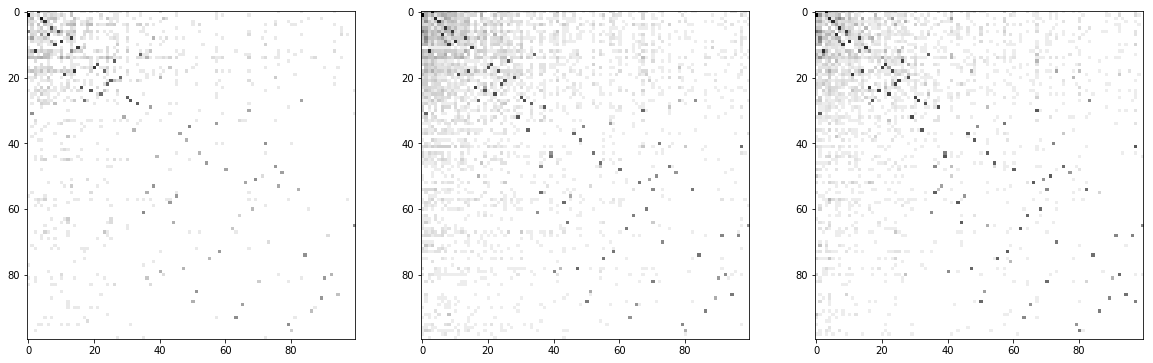

In [39]:
cut = 100
ca.plot_grs(grs_m[0][:cut, :cut],
            grs_m[1][:cut, :cut],
            grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [62]:
grs[1].max(1)

array([ 5174, 12163,  2098,  2436,  1758,  1603,  1707,  1804,  1286,
        2410,  1007,    15,  1049,   692,   853,   730,   492,   612,
         643,   240,   858,   718,   541,   496,    20,   651,   486,
         406,   652,   249,   330,   277,   430,   340,   253,   206,
         169,   193,   129,   212,   223,   149,   216,   232,   131,
           5,   156,   167,    90,    78,   128,   149,   137,   243,
          38,   158,   108,    89,   133,   170,   106,     6,   112,
         109,    51,    69,    44,    76,    77,    66,    88,    18,
           3,    63,   129,    65,     4,    47,    19,   127,    63,
          61,    90,    66,    29,    45,    47,    76,    20,    24,
          56,    41,    31,    77,    29,    32,    58,    35,    30,
          57,     8,    25,     2,    32,    23,     4,    32,    40,
          42,    50,    52,    43,    10,    25,     4,    14,    47,
          27,    16,    46,    29,    29,    24,    45,    35,    13,
          22,    15,

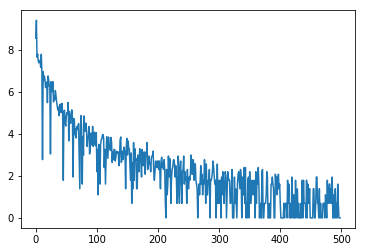

In [61]:
plt.plot(np.log(grs[1].max(1) + 1))
plt.show()

In [14]:
grs_m[1][0].astype(int)[:10]

array([   7,   41,   14, 5174,   23,   16,   18,   10,   24,   12])

In [15]:
grs_m[1][0].astype(int)

array([  0,   2,   0, 353,   2,   3,   5,   2,   2,   0,   1,   0,   0,
         6,   0,   0,   1,   1,   0,   2,   0,   1,   0,   0,   0,   1,
         1,   1,   1,   0,   2,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   2,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   

In [16]:
gb = pickle.load(open("./gb_rep_to_rep", 'rb'))

In [22]:
preds = gb.predict_proba(embs[1])[:,1].reshape((grs[1].shape[0] - 1, grs[1].shape[1] - 1))

In [44]:
grs[0].shape

(253, 253)

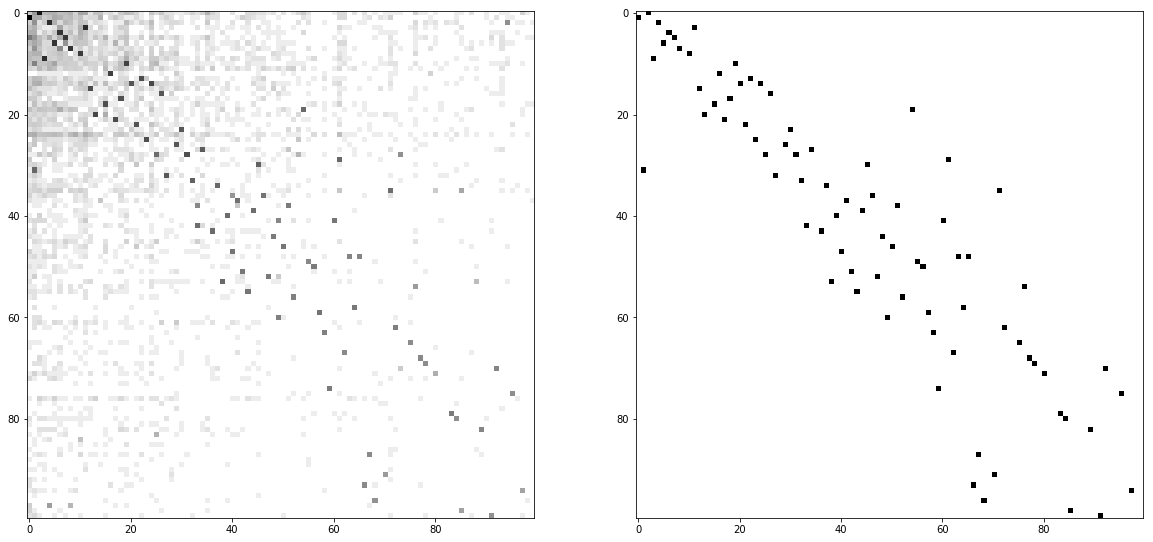

In [25]:
cut = 100
ca.plot_grs(grs[1][:cut,:cut], preds[:cut,:cut] > 0.5, log =1, s = 20)

In [40]:
len(arrays)

156

In [42]:
len([x for x in arrays if len(x) > 3])

46

In [46]:
weights = ca.get_weights(grs[1], [x for x in arrays if len(x) > 3])

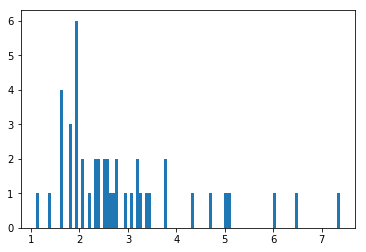

In [54]:
plt.hist(np.log([np.median(x) + 1 for x in weights]), bins = 100)
plt.show()

In [55]:
[np.median(x) + 1 for x in weights]

[628.5,
 414.0,
 1604.0,
 31.0,
 22.0,
 25.0,
 157.0,
 150.0,
 44.0,
 10.0,
 77.0,
 14.5,
 16.0,
 44.0,
 13.0,
 24.0,
 14.0,
 13.5,
 11.0,
 110.0,
 12.0,
 16.0,
 19.0,
 7.0,
 9.0,
 5.0,
 11.0,
 7.0,
 12.0,
 6.0,
 26.0,
 5.0,
 6.0,
 29.5,
 7.0,
 7.0,
 10.0,
 7.0,
 7.0,
 6.0,
 8.0,
 3.0,
 8.0,
 5.0,
 5.0,
 4.0]

In [28]:
arrays = ca.restore_arrays_all(preds > 0.5)

In [36]:
arrays_sp = [[reads[1].index_to_cluster[x] for x in y] for y in arrays]

In [38]:
ca.write_list_of_lists("./arrays_sp_mammonth", arrays_sp)